### Compare CONUS2 and SNOTEL SWE ###
DTT, 06/23
### Need to update the documentation for SWE (copied Streamflow notebook)

This notebook reads in CSVs of CONUS2 daily mean flow [cms] and daily mean USGS flow [cms] and creates comparison hydrographs. Gages have been matched between the two csv's to make sure that we're comparing viable gage locations in `1_Organize_Streamflow.ipynb`. 

Inputs:
- CONUS2 daily mean flow csv in [cms], ouput from `1_Organize_Streamflow.ipynb`
- USGS daily mean flow csv in [cms], ouput from `1_Organize_Streamflow.ipynb` 
- USGS gage metadata csv, ouput from `1_Organize_Streamflow.ipynb` 

Outputs:
- Hydrographs of USGS and CONUS2 flow

Notes:

In [5]:
import sys
from parflow.tools.io import read_pfb,write_pfb
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
#import geopandas as gpd

In [6]:
water_year = 2003
# Directory containing output csv's from `Make_CONUS2_streamflow_csv.py`
#organized_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/Streamflow/Organized_Daily_Flow'
organized_dir = '/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/WTD/Organized_Daily_WTD'


# Where you want to save plots, etc. to
#plot_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/Streamflow/Figures'
plot_dir = '/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/spinup_Validation/WTD/daily'
print(f'Figures saving to: {plot_dir}')


# names of csv files
pf_csv = 'PFCONUS2_Daily_matched_WTD_m_2003.csv'
obs_csv = 'USGS_Daily_matched_WTD_m_2003.csv'
metadata_csv = 'USGS_metadata_matched_WTD_m_2003.csv'
stats_csv = 'Summary_WTD_Daily_CONUS2_WY2003.csv'

Figures saving to: /hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/spinup_Validation/WTD/daily


### Read in files
Read in PF flow, USGS flow, USGS metadata, and calculated stats from `SaveStreamflowStats.ipynb`

In [7]:
### read in CONUS2 daily flow matched csv
pfdata = pd.read_csv(f'{organized_dir}/{pf_csv}',index_col=['site_id'])
#pf_flow_matched = pfdata.drop(columns=['USGS_lat', 'USGS_lon', 'x_new_adj', 'y_new_adj'])
pfdata.head()

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
290955098562101,0.046598,0.117977,0.220182,0.257405,0.284448,0.303802,0.317972,0.244333,0.002561,0.000000,...,0.066616,0.030094,0.036585,0.041375,0.045606,0.042465,0.046457,0.120872,0.222234,0.0
291136099375801,0.153622,0.322058,0.391806,0.436653,0.473755,0.503918,0.521985,0.256727,0.031601,0.020330,...,1.272928,1.244795,1.222374,1.213699,1.207622,1.197916,1.183117,1.171317,1.164986,0.0
292045099081801,0.179284,0.348520,0.415460,0.462341,0.501713,0.531404,0.538530,0.464910,0.064337,0.043442,...,1.252013,1.228831,1.211517,1.203631,1.199162,1.195820,1.195169,1.194164,1.195079,0.0
292117098524701,0.173391,0.401435,0.502473,0.568874,0.623283,0.662633,0.692886,0.459583,0.015222,0.037403,...,1.056265,0.976283,0.967152,0.980743,0.999757,1.010488,1.015186,1.029755,1.045833,0.0
292505098254002,0.032914,0.038503,0.043972,0.083968,0.311845,0.454438,0.513418,0.406310,0.001405,0.000000,...,1.143994,1.092434,1.073321,1.073828,1.084173,1.094581,1.101546,1.114014,1.128256,0.0


In [8]:
### read in USGS daily flow matched csv
usgsdata = pd.read_csv(f'{organized_dir}/{obs_csv}',index_col=['site_id']) 
usgsdata.head()
# # change zero values in USGS df so that we can calculate stats without errors
# usgsdata = usgsdata.where(usgsdata>0, 0.0001)

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
290955098562101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-14.825472,-14.819376,-14.828520,-14.871192,-14.892528,-14.935200,-14.938248,-14.907768,-14.892528,-14.901672
291136099375801,45.476160,49.371504,57.290208,55.22976,54.150768,52.776120,52.349400,49.685448,44.906184,43.120056,...,30.967680,30.540960,30.129480,29.708856,29.340048,28.959048,28.648152,28.382976,28.114752,27.852624
292045099081801,43.833288,43.988736,44.052744,44.08932,44.217336,44.189904,44.250864,44.171616,43.988736,43.665648,...,44.284392,44.162472,44.086272,43.958256,43.924728,43.897296,43.888152,43.918632,43.949112,43.943016
292117098524701,11.609832,11.667744,11.707368,11.78052,11.850624,11.868912,11.884152,11.853672,11.618976,11.478768,...,12.874752,12.780264,12.701016,12.594336,12.548616,12.515088,12.512040,12.539472,12.563856,12.621768
292505098254002,-19.808952,-19.699224,-19.607784,-19.56816,-19.641312,-19.598640,-19.559016,-19.644360,-19.891248,-20.083272,...,-20.241768,-20.116800,-20.238720,-20.369784,-20.321016,-20.543520,-20.531328,-20.616672,-20.659344,-20.622768


In [9]:
### read in USGS streamflow gage metadata for all gages with flow in October
usgs_gage_metadata = pd.read_csv(f'{organized_dir}/{metadata_csv}',index_col=['site_id'])#, 
#usgs_gage_metadata = usgs_gage_metadata.drop(columns=['Unnamed: 0'])
#usgs_all_gages = usgs_all_gages.transpose() #transpose df for easier plotting
usgs_gage_metadata

,site_type,agency,site_name,site_id_agency,site_query_url,date_metadata_last_updated,latitude,longitude,state,huc,...,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,conus1_x,conus1_y,conus2_x,conus2_y,num_obs
site_id,,,,,,,,,,,,,,,,,,,,,
290955098562101,groundwater well,USGS,TD-68-49-813 (Devine),290955098562101,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,29.165778,-98.939411,TX,12110109,...,C,3200.00,3200.0,L,8653-00270,NaN,NaN,2019,485,327
291136099375801,groundwater well,USGS,YP-69-51-606 (E. Uvalde 3),291136099375801,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,29.193573,-99.632830,TX,12110106,...,C,1400.00,1400.0,D,8653-BQ101,NaN,NaN,1951,490,338
292045099081801,groundwater well,USGS,TD-69-47-306,292045099081801,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,29.346068,-99.138647,TX,12110107,...,C,1600.00,1600.0,S,8653-00270,NaN,NaN,2000,506,362
292117098524701,groundwater well,USGS,TD-68-41-301,292117098524701,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,29.354957,-98.880028,TX,12100302,...,C,710.00,710.0,S,8653-00270,NaN,NaN,2025,506,331
292505098254002,groundwater well,USGS,AY-68-37-522 (San Antonio Transect A-2),292505098254002,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,29.418289,-98.428071,TX,12100301,...,C,1075.00,1075.0,O,8653-00270,NaN,NaN,2069,512,363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474436096140801,groundwater well,USGS,E03-R 149N44W12BADA 01 000065...,474436096140801,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,47.743294,-96.235442,MN,9020303,...,U,69.00,76.0,D,MN-18000,1867.0,1575.0,2263,2501,340
474719096163100,groundwater well,USGS,E05-R 150N44W27ABBAA 01 L058,474719096163100,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,47.788900,-96.276125,MN,9020303,...,U,18.06,22.0,S,MN-18000,1864.0,1580.0,2260,2506,56
480034105195401,groundwater well,USGS,26N49E13ACAB01 Wolf Point,480034105195401,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,48.009364,-105.331008,MT,10060002,...,U,180.00,180.0,S,MT076,1185.0,1641.0,1610,2561,365


In [10]:
usgs_gage_metadata.columns

Index(['site_type', 'agency', 'site_name', 'site_id_agency', 'site_query_url',
       'date_metadata_last_updated', 'latitude', 'longitude', 'state', 'huc',
       'tz_cd', 'doi', 'observation_id', 'site_id:1', 'var_id',
       'start_date_listed', 'end_date_listed', 'is_current', 'is_series',
       'first_date_data_available', 'last_date_data_available', 'record_count',
       'date_verified_through', 'latest_download_date', 'file_path',
       'coord_meth_cd', 'coord_acy_cd', 'coord_datum_cd', 'dec_coord_datum_cd',
       'district_cd', 'state_cd', 'county_cd', 'country_cd', 'land_net_ds',
       'map_nm', 'map_scale_fc', 'alt_va', 'alt_meth_cd', 'alt_acy_va',
       'alt_datum_cd', 'basin_cd', 'topo_cd', 'instruments_cd',
       'construction_dt', 'inventory_dt', 'drain_area_va',
       'contrib_drain_area_va', 'local_time_fg', 'reliability_cd',
       'gw_file_cd', 'nat_aqfr_cd', 'aqfr_cd', 'aqfr_type_cd', 'well_depth_va',
       'hole_depth_va', 'depth_src_cd', 'project_no', 'con

In [11]:
### read in USGS daily flow matched csv
stats_df = pd.read_csv(f'{organized_dir}/{stats_csv}',index_col=['site_id']) 
stats_df

,latitude,longitude,conus2_x,conus2_y,huc,HUC2,USGS_mean_mm,PF_mean_mm,pf_minus_obs,absrelbias,bias,pbias,srho,r2,rmse,mse
site_id,,,,,,,,,,,,,,,,
290955098562101,29.165778,-98.939411,2019,485,12110109,12,0.000112,0.246099,89.789752,2459.993198,2459.993198,245999.319760,NaN,-5.301381e+38,0.312043,0.097371
291136099375801,29.193573,-99.632830,1951,490,12110106,12,30.575497,0.795623,-10044.115448,0.971900,-0.971900,-97.189975,0.555330,-5.608879e+00,29.799566,888.014144
292045099081801,29.346068,-99.138647,2000,506,12110107,12,43.010270,0.787037,-15282.449350,0.981550,-0.981550,-98.154955,0.750594,-6.788512e+01,42.160595,1777.515773
292117098524701,29.354957,-98.880028,2025,506,12100302,12,11.646980,0.730964,-3588.348393,0.930793,-0.930793,-93.079337,0.801893,-4.884833e+00,10.638994,113.188199
292505098254002,29.418289,-98.428071,2069,512,12100301,12,0.000101,0.577122,210.613008,5770.219389,5770.219389,577021.938861,NaN,-3.635421e+39,0.817142,0.667721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474436096140801,47.743294,-96.235442,2263,2501,9020303,9,2.353664,0.217896,-720.713819,0.900616,-0.900616,-90.061561,0.696275,-9.945772e+00,2.062262,4.252923
474719096163100,47.788900,-96.276125,2260,2506,9020303,9,4.163576,0.458035,-65.977403,0.282970,-0.282970,-28.297023,0.598683,1.777875e-01,1.361427,1.853485
480034105195401,48.009364,-105.331008,1610,2561,10060002,10,13.325806,0.607976,-4642.007883,0.954376,-0.954376,-95.437604,0.481860,-1.051956e+05,12.720239,161.804471


In [12]:
len(usgsdata.columns)

365

## Make USGS-CONUS2 timeseries plots 
Plot a hydrograph at each gage for USGS observations and PF-CONUS2  
_(This will take a long time to do for CONUS)_

In [13]:
pfdata.columns

Index(['2002-10-01', '2002-10-02', '2002-10-03', '2002-10-04', '2002-10-05',
       '2002-10-06', '2002-10-07', '2002-10-08', '2002-10-09', '2002-10-10',
       ...
       '2003-09-21', '2003-09-22', '2003-09-23', '2003-09-24', '2003-09-25',
       '2003-09-26', '2003-09-27', '2003-09-28', '2003-09-29', '2003-09-30'],
      dtype='object', length=365)

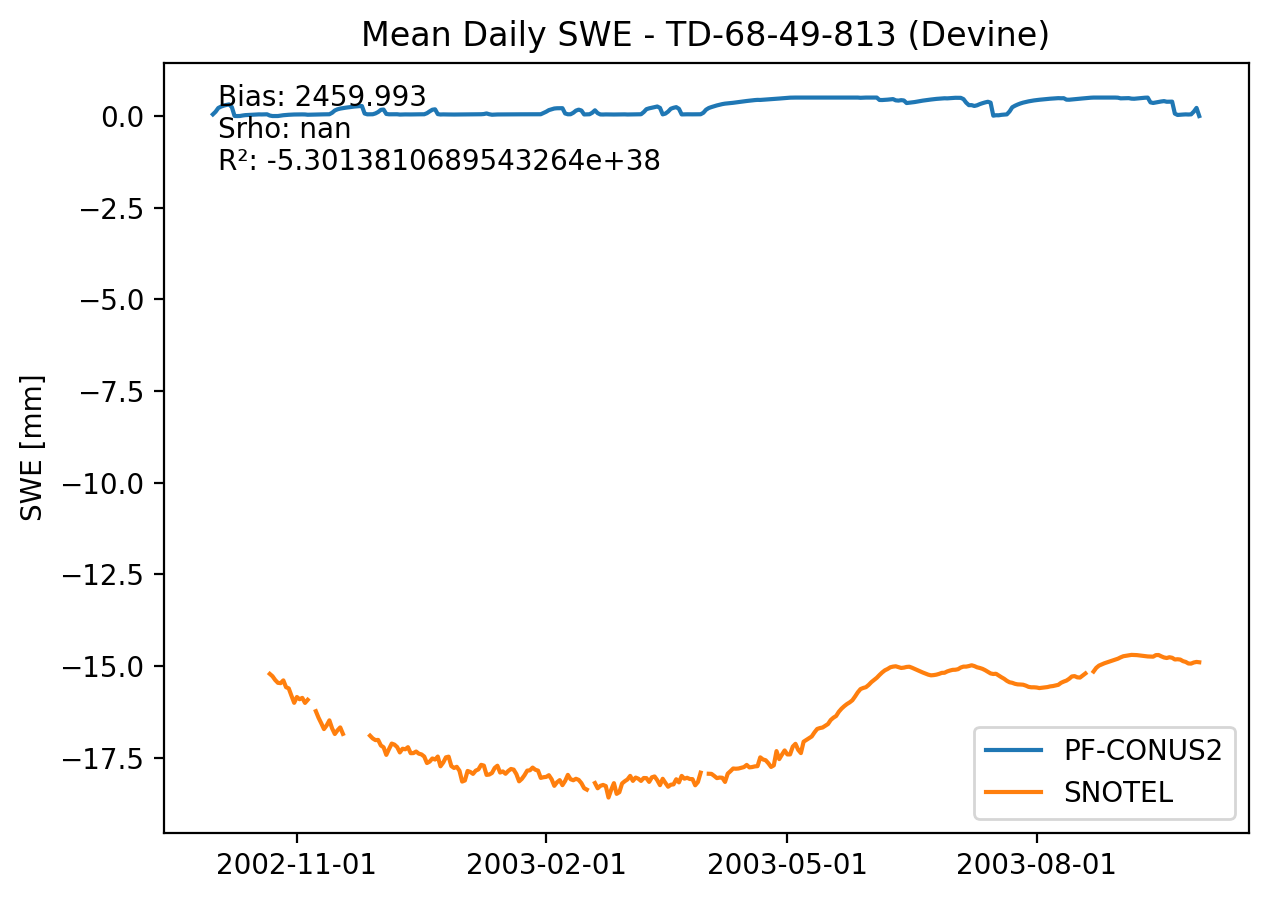

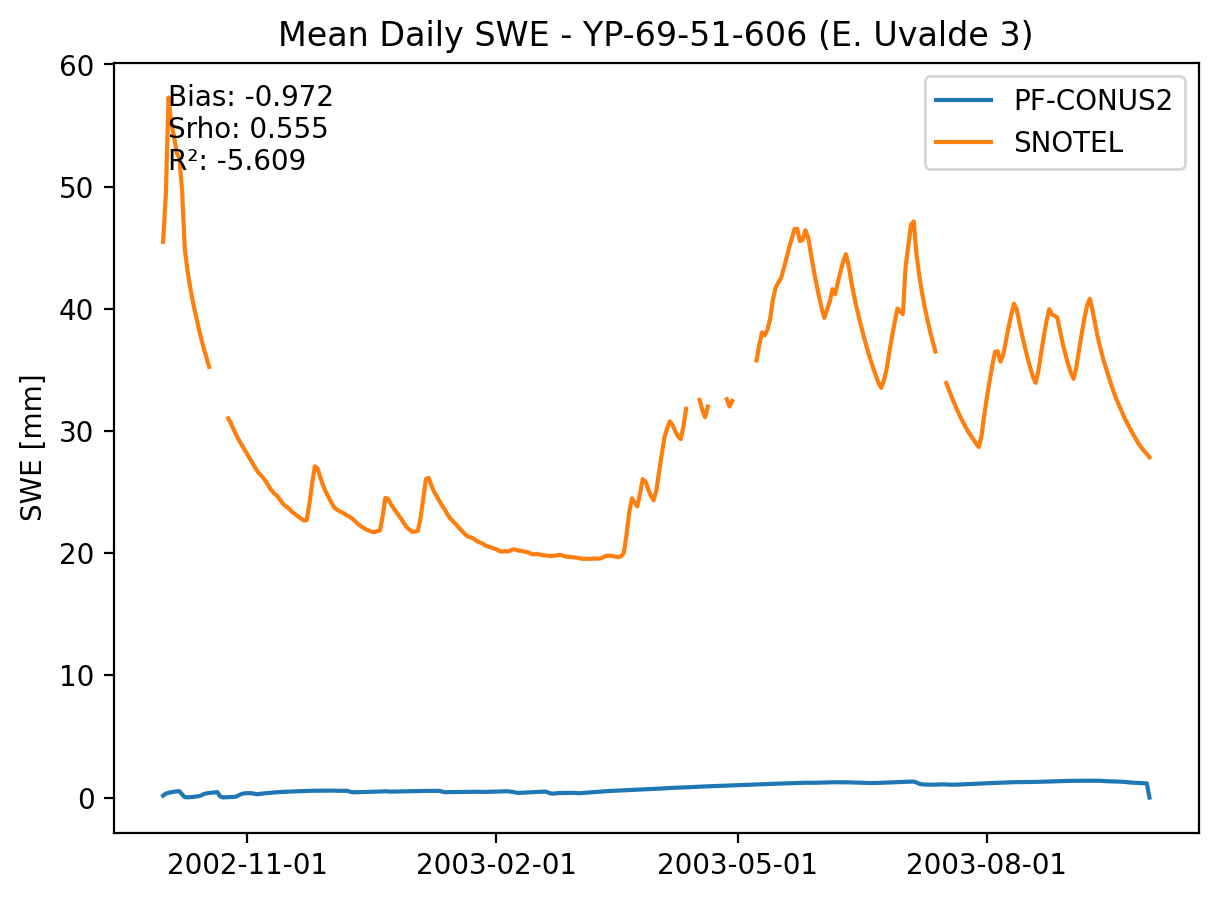

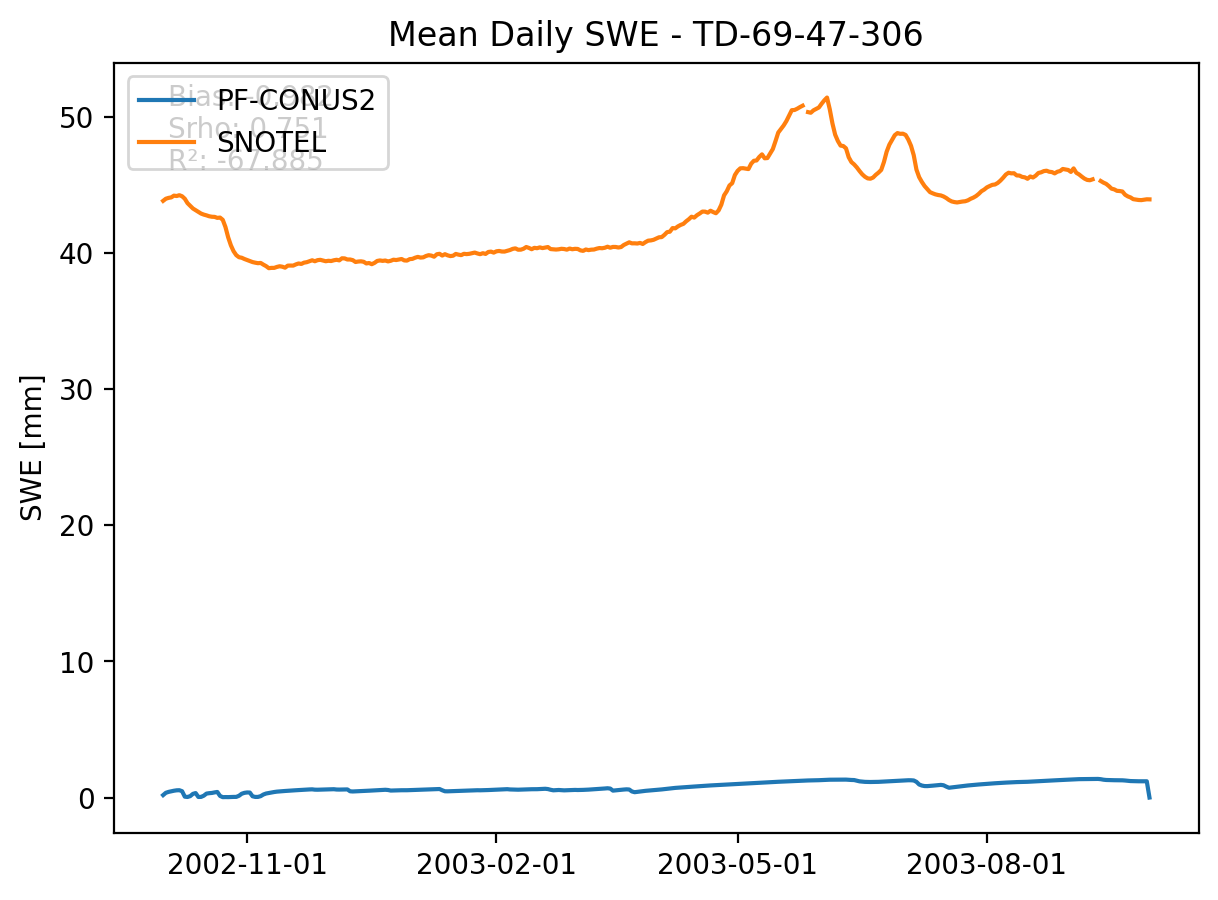

In [15]:
### Make a plot of CONUS2 vs observed
xlength = range(len(usgsdata.columns))
xlength = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in pfdata.columns]

for i in range(3):#(len(usgsdata.index)):
    gage = usgsdata.index[i]
    station_name = usgs_gage_metadata['site_name'][gage]
    

    # make hydrographs
    fig, ax = plt.subplots(figsize=(7,5), dpi = 200)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    #plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    ax.plot(xlength, pfdata.loc[gage],label= 'PF-CONUS2')
    ax.plot(xlength, usgsdata.loc[gage],label= 'SNOTEL')
    #plt.gcf().autofmt_xdate()
    ax.set_ylabel('SWE [mm]')
    #plt.xlabel('Days')
    plt.title(f'Mean Daily SWE - {station_name}')
    plt.annotate(f'Bias: {round(stats_df.bias.iloc[i],3)}\nSrho: {round(stats_df.srho.iloc[i],3)}\nR\u00b2: {round(stats_df.r2.iloc[i],3)}',xy=(0.05,0.86), xycoords = 'axes fraction')
    ax.legend()
    # plt.savefig(f'{plot_dir}/Timeseries_WY2003/SWE_Timeseries_{usgsdata.index[i]}_mm.png',facecolor='white', transparent=False, bbox_inches="tight")
    # plt.close()

## Make CONUS2 summary stat plots

USGS vs PF mean daily 

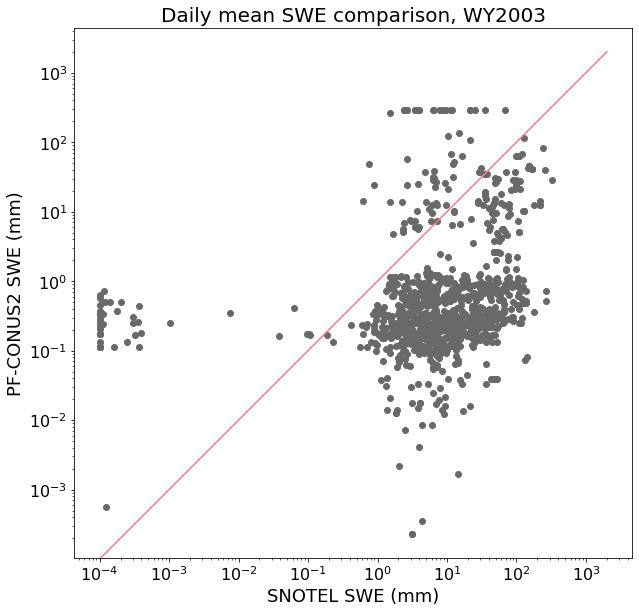

In [16]:
# Scatter plot of daily mean flow for  WY2003, PF vs. USGS
fig = plt.figure(figsize=(10,10), dpi=72)
ax = fig.add_subplot()

ax.scatter(stats_df['USGS_mean_mm'], stats_df['PF_mean_mm'], color = 'dimgrey')
ax.plot(range(2000), color = 'lightcoral')
plt.ylabel('PF-CONUS2 SWE (mm)',fontsize=18)
plt.xlabel('SNOTEL SWE (mm)',fontsize=18)
plt.title('Daily mean SWE comparison, WY2003',fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
# square plot
ax.set_aspect('equal', adjustable='box')#########THIS IS BROKENNNNNNNNNNN
#plt.savefig(f'{plot_dir}/WY2003_daily_SWE_comparison_scatter.png')


## Map Plots

In [17]:
from PIL import Image

# Read in CONUS2 mask and HUC2 png for map plot border and HUC2 outlines
CONUS2_mask = Image.open('/hydrodata/PFCLM/CONUS2_baseline/inputs/domain_files/CONUS2.0.Final1km.Mask.tif')
mask_array = np.array(CONUS2_mask)
HUC2_outline = Image.open('/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/mapping_scripts/CONUS2_outline_with_HUC2_noSqrBorder.png')


(-0.5, 4442.0, -0.5, 3256.0)

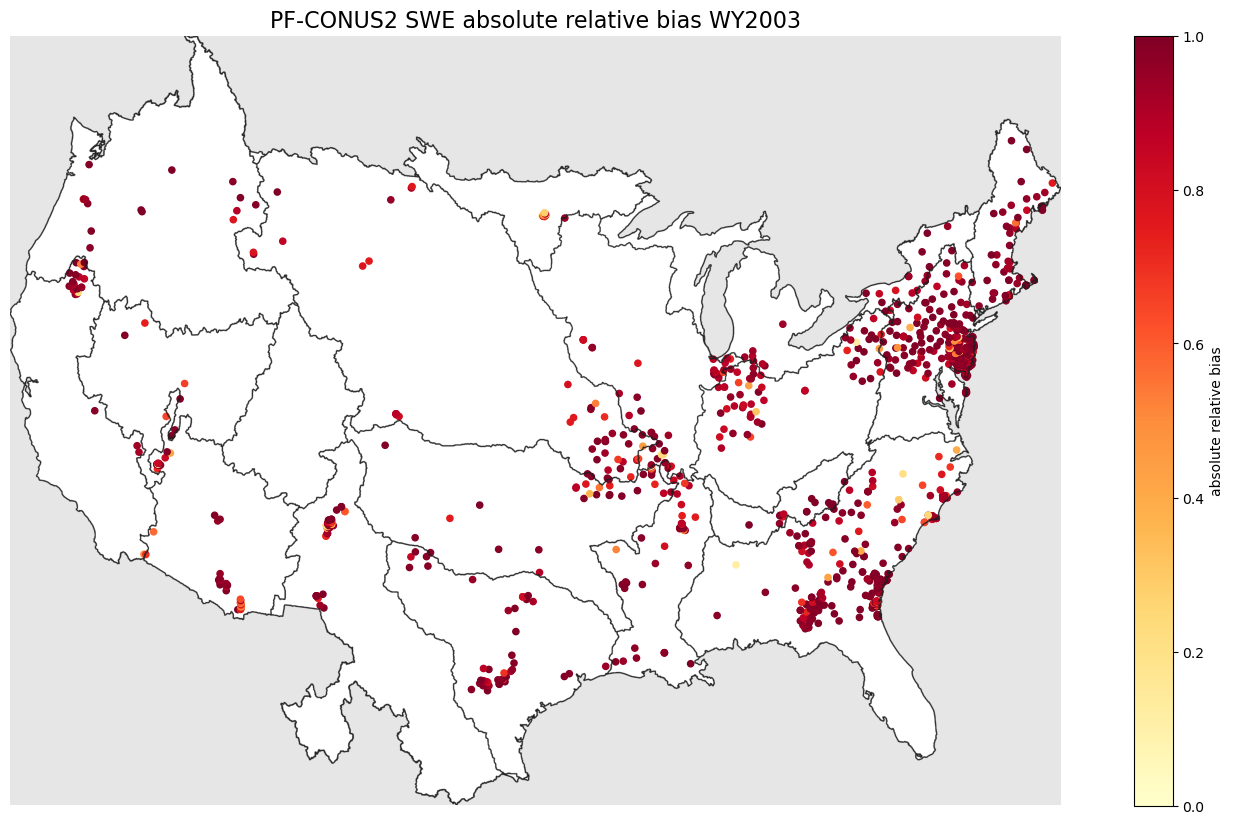

In [18]:
### Absolute Relative Bias
### Good values are closer to 0.0
fig, ax = plt.subplots(1,1,figsize=(19,10))
ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
ax.imshow(mask_array[::-1,:], origin='lower', cmap='Greys_r', alpha = 0.1) # CONUS2 outline 
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.absrelbias, cmap='YlOrRd', s=20, vmin = 0, vmax = 1, zorder=1)
plt.colorbar(points, label = 'absolute relative bias')
plt.title(f'PF-CONUS2 SWE absolute relative bias WY{water_year}', fontsize = 16)
plt.axis('off')
# plt.savefig(f'{plot_dir}/PFCONUS2_SWE_AbsRelBias_Map_WY{water_year}.png',\
#             dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

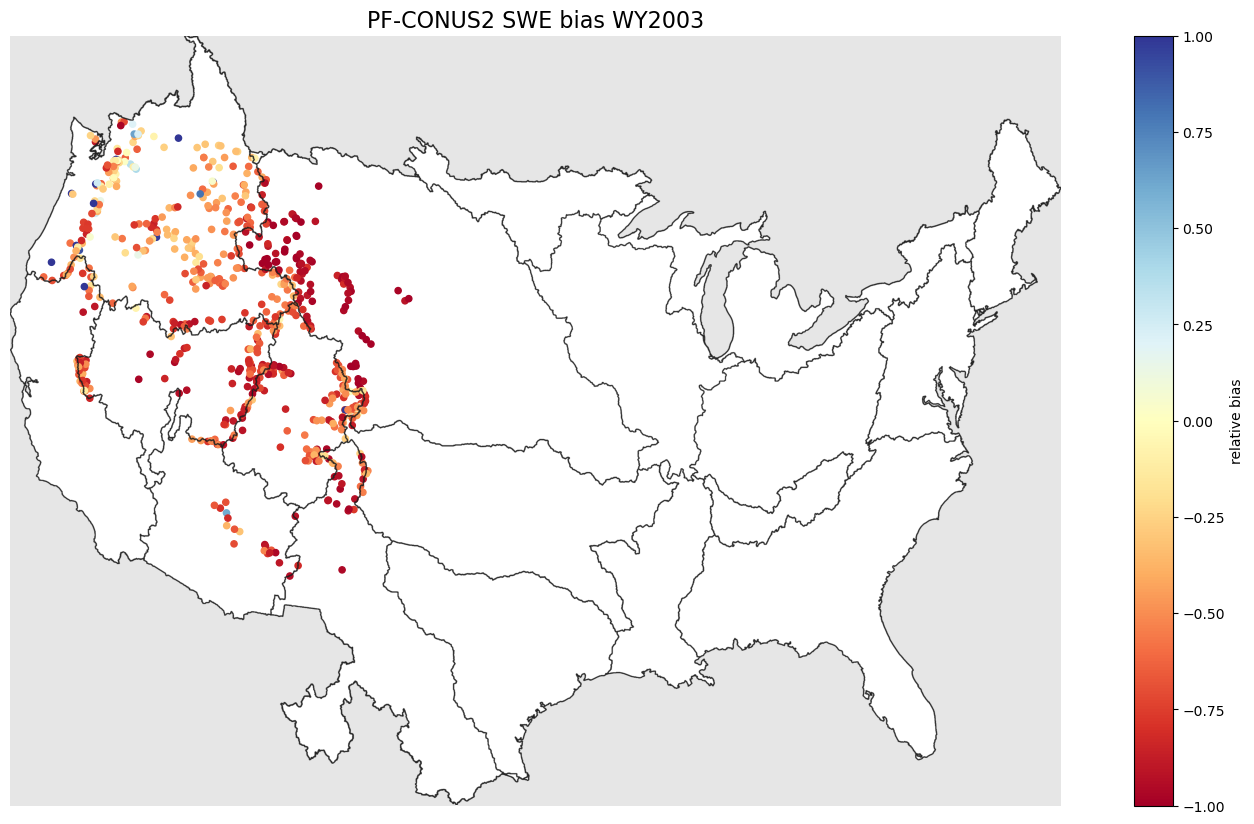

In [29]:
### Relative Bias
### Good values are closer to 0.0, positive is PF overestimation, negative is PF underestimation
fig, ax = plt.subplots(1,1,figsize=(19,10))
ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
ax.imshow(mask_array[::-1,:], origin='lower', cmap='Greys_r', alpha = 0.1) # CONUS2 outline 
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.bias, cmap='RdYlBu', s=20, vmin = -1, vmax = 1, zorder=1)
plt.colorbar(points, label = 'relative bias')
plt.axis('off')
plt.title(f'PF-CONUS2 SWE bias WY{water_year}', fontsize = 16)
# plt.savefig(f'{plot_dir}/PFCONUS2_SWE_RelBias_Map_WY{water_year}.png',\
#             dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

In [14]:
print(stats_df.pf_minus_obs.max())
stats_df.pf_minus_obs.min()

501896.885179908


-2376575.259631489

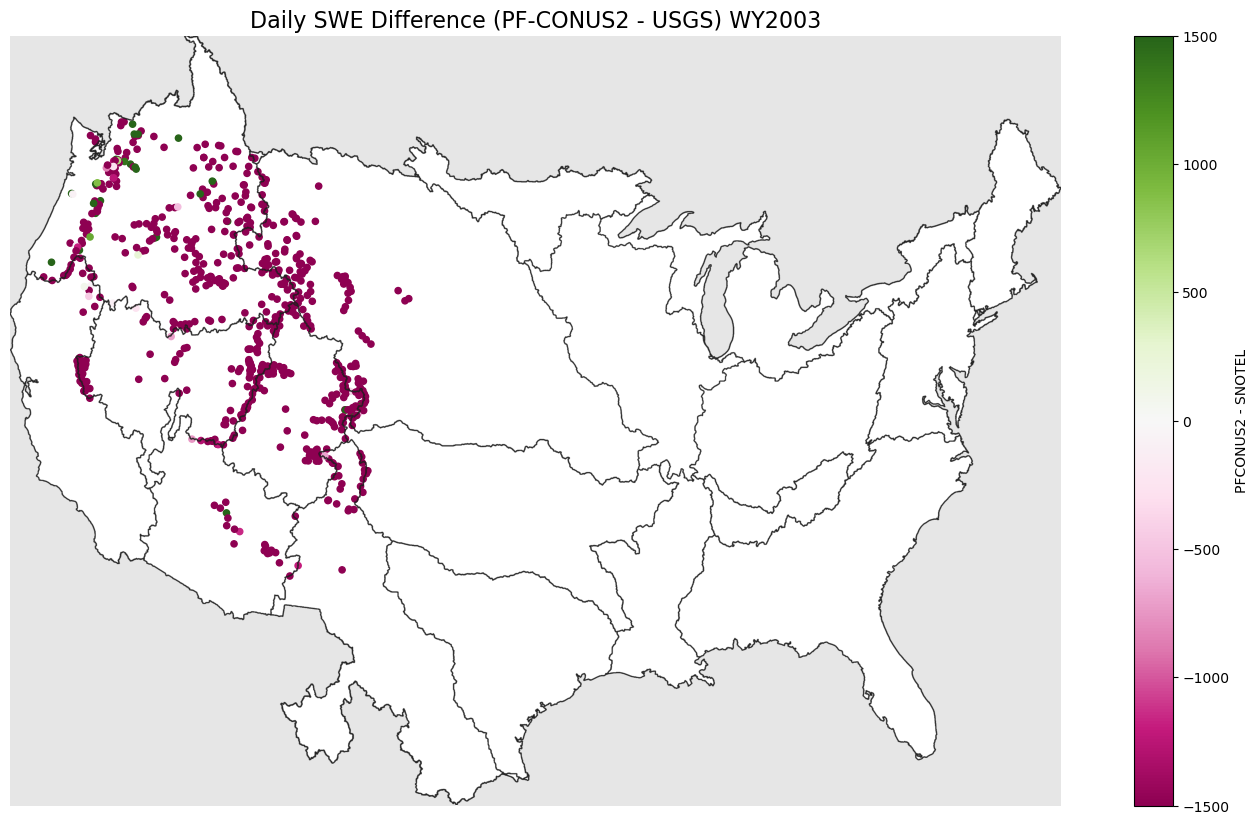

In [30]:
### PF - USGS
### Good values are closer to 0.0, positive is PF overestimation, negative is PF underestimation
fig, ax = plt.subplots(1,1,figsize=(19,10))
ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
ax.imshow(mask_array[::-1,:], origin='lower', cmap='Greys_r', alpha = 0.1) # CONUS2 outline 
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.pf_minus_obs, cmap='PiYG', vmin = -1500, vmax = 1500, s=20, zorder=1)
plt.colorbar(points, label = 'PFCONUS2 - SNOTEL') #
plt.title(f'Daily SWE Difference (PF-CONUS2 - USGS) WY{water_year}', fontsize = 16)
plt.axis('off')
plt.savefig(f'{plot_dir}/PFCONUS2_SWE-Diff_PF-SNOTEL_WY{water_year}.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

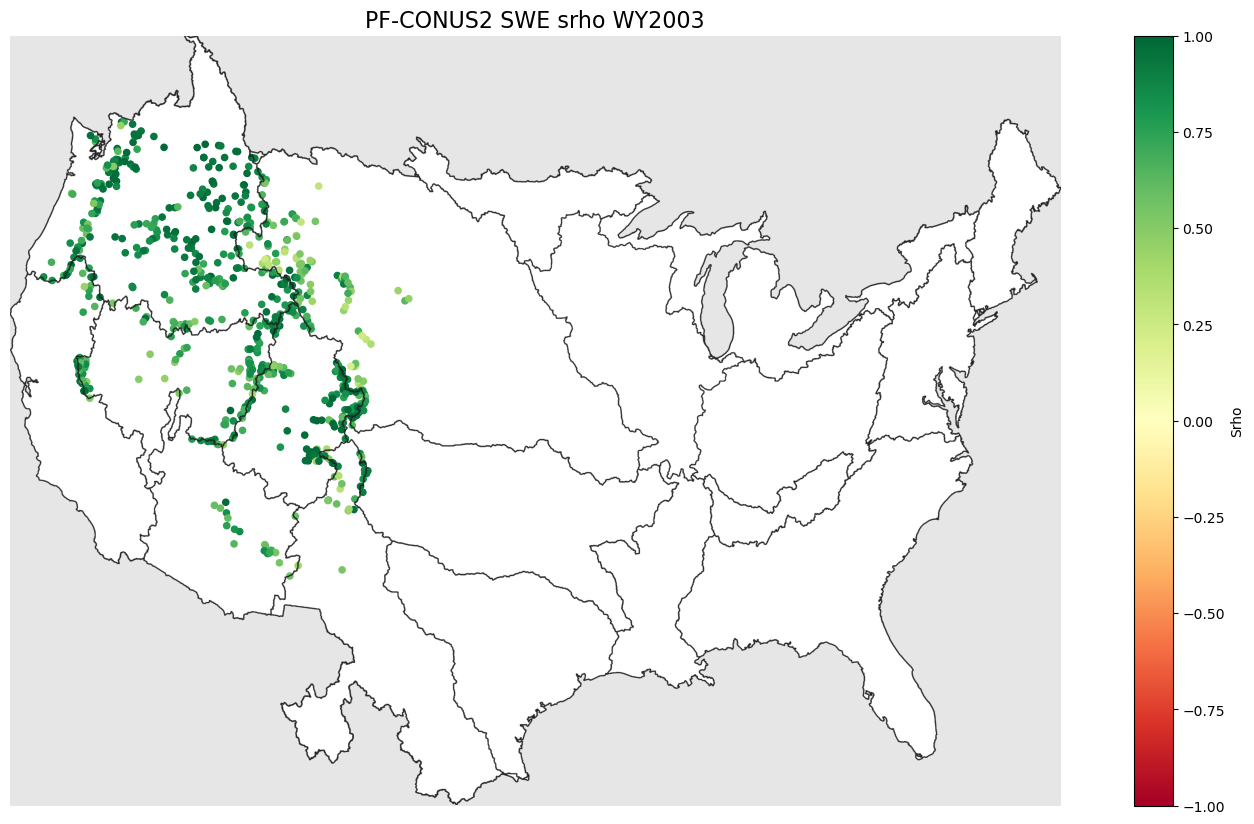

In [31]:
### Spearmans's Rho
### Good values are closer to 0.0
fig, ax = plt.subplots(1,1,figsize=(19,10))
ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
ax.imshow(mask_array[::-1,:], origin='lower', cmap='Greys_r', alpha = 0.1) # CONUS2 outline 
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.srho, s=20, vmin = -1, vmax = 1, cmap = 'RdYlGn', zorder=1)
plt.colorbar(points, label = 'Srho')
plt.axis('off')
plt.title(f'PF-CONUS2 SWE srho WY{water_year}', fontsize = 16)
plt.savefig(f'{plot_dir}/PFCONUS2_SWE_Srho_Map_WY{water_year}.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

In [ ]:

# plt.figure(figsize=(5,5))
# n, bins_limits, patches = plt.hist(obsv, bins=np.logspace(np.log10(1e-6),np.log10(1e7), 80), color='r', alpha=0.5, label='USGS')
# plt.hist(simv, bins = bins_limits, color='b', alpha=0.5, label='CONUS2')
# plt.xlabel('streamflow ($\mathregular{m^3}$/h)')
# plt.ylabel('Frequency')
# plt.xscale('log')
# plt.legend()
# plt.xlim(1e-2,1e8)
